In [1]:
import os
import shutil
from zipfile import ZipFile
from glob import glob
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

# Set seed for reproducible randomness
seed = 1
np.random.seed(seed)
rng = np.random.RandomState(seed)

In [2]:
# A map of the gesture directories to their class names
directory_map = {
    'Brush_teeth': 'brush_teeth',
    'Climb_stairs*': 'climb_stairs',
    'Comb_hair': 'comb_hair',
    'Descend_stairs': 'descend_stairs',
    'Drink_glass*': 'drink_glass',
    'Eat_meat': 'eat_meat',
    'Eat_soup': 'eat_soup',
    'Getup_bed*': 'getup_bed',
    'Liedown_bed': 'liedown_bed',
    'Pour_water*': 'pour_water',
    'Sitdown_chair*': 'sitdown_chair',
    'Standup_chair*': 'standup_chair',
    'Use_telephone': 'use_telephone',
    'Walk*': 'walk'
}

classes = list(directory_map.values())

In [3]:
def file_to_numpy(file):
    """Convert acceleration parameter .txt file to np.ndarray"""
    with open(file) as f:
        X = []
        for line in f:
            Ax, Ay, Az = line.strip('\n').split()
            X.append([float(Ax), float(Ay), float(Az)])
    return np.array(X)

In [4]:
X, y = [], []
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00283/ADL_Dataset.zip'

try:
    # Download the dataset
    path, zip_path = 'HMP_Dataset', 'ADL_Dataset.zip'
    print('Downloading dataset from {} ...'.format(url))
    response = requests.get(url)
    with open(zip_path, 'wb') as f:
        print('Writing {} ...'.format(zip_path))
        f.write(response.content)
    with ZipFile(zip_path, 'r') as zip_ref:
        print('Extracting {} ...'.format(zip_path))
        zip_ref.extractall()
except:
    raise
else:
    print('Reading data into Numpy arrays ...')
    for pattern, label in directory_map.items():
        for folder in glob(os.path.join(path, pattern)):
            for txt in glob(os.path.join(folder, '*.txt')):
                X.append(file_to_numpy(txt))
                y.append(label)
    print('Done!')
finally:
    os.remove(zip_path)
    shutil.rmtree(path)

Writing ADL_Dataset.zip ...
Extracting ADL_Dataset.zip ...
Reading data into Numpy arrays ...
Done!


In [5]:
# Split the data into training, validation and test sets (65-20-15)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.35, shuffle=True, random_state=rng)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.43, shuffle=True, random_state=rng)

# Display the split sizes
print('Training set size: {}'.format(len(y_train)))
print('Validation set size: {}'.format(len(y_val)))
print('Test set size: {}'.format(len(y_test)))

Training set size: 636
Validation set size: 195
Test set size: 148


In [6]:
def plot_signal(XX, figsize=(7, 4), title=None):
    """Visualize an accelerometer signal"""
    title = 'Accelerometer signals' if title is None else title
    labels = ['X', 'Y', 'Z']
    colors = ['blue', 'red', 'green']
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=figsize)
    for i, ax in enumerate(axs.flat):
        ax.plot(XX[:, i], label=labels[i], color=colors[i])
        ax.legend(loc='upper right')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0, top=0.92)
    fig.suptitle(title)
    plt.show()

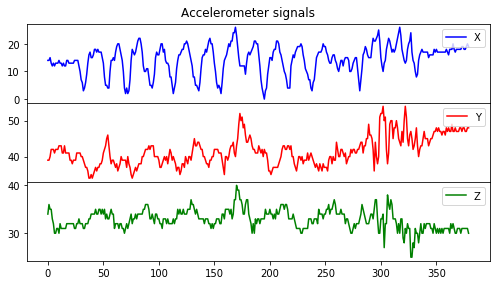

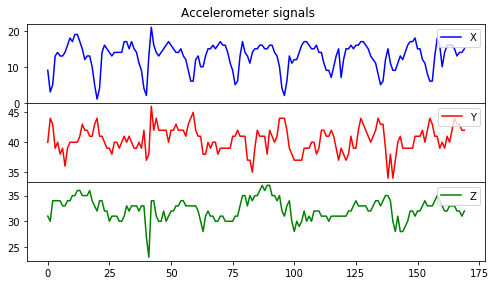

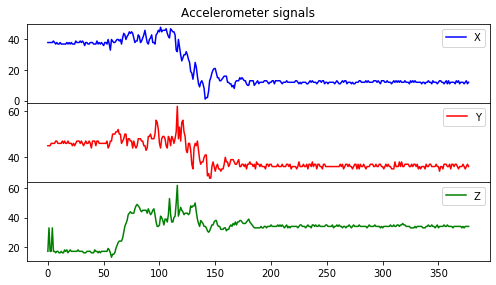

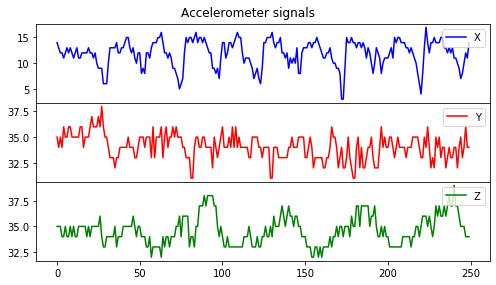

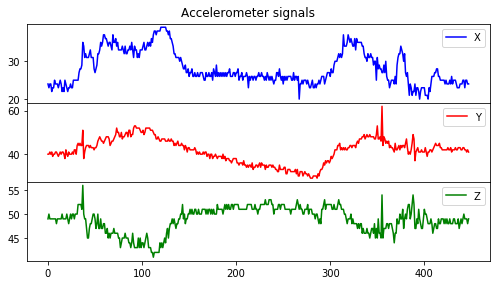

In [7]:
# Plot some sample accelerometer signals from the training set
for signal in X_train[:5]:
    plot_signal(signal)

In [8]:
from sequentia.preprocessing import Preprocess

# Create a preprocessing pipeline
pre = Preprocess()
pre.standardize()
pre.filtrate(n=5, method='median')
pre.downsample(n=5, method='decimate')
pre.fft()
pre.summary()

          Preprocessing summary:          
1. Standardization
------------------------------------------
2. Filtering:
   Median filter with window size (n=5)
------------------------------------------
3. Downsampling:
   Decimation with downsample factor (n=5)
------------------------------------------
4. Discrete Fourier Transform


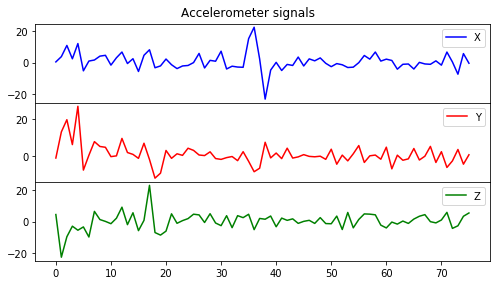

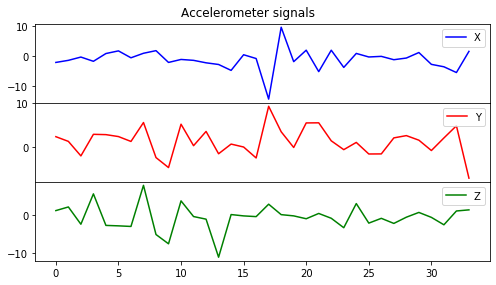

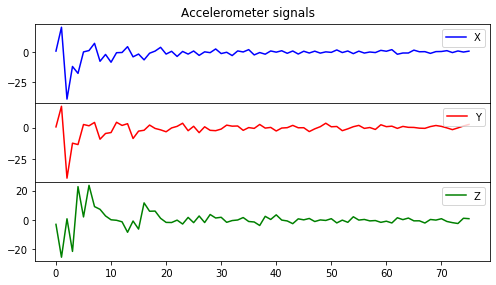

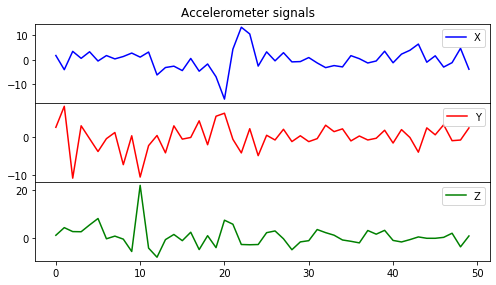

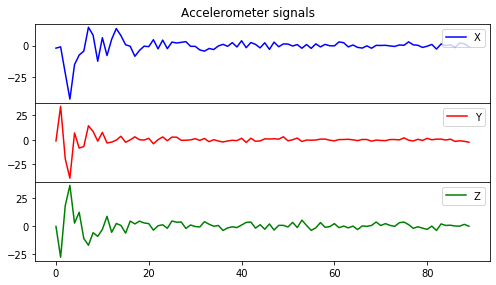

In [9]:
# Plot the same sample accelerometer signals, but preprocessed
for signal in pre.transform(X_train[:5]):
    plot_signal(signal)

In [10]:
# Apply the preprocessing pipeline to each dataset split
X_train, X_val, X_test = pre.transform(X_train), pre.transform(X_val), pre.transform(X_test)

In [11]:
def show_results(acc, cm, dataset, labels):
    """Display accuracy and confusion matrix"""
    df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df, annot=True)
    plt.title('Confusion matrix for {} set predictions'.format(dataset), fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    # Fix for matplotlib bug that cuts off top/bottom of seaborn visualizations
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.show()
    print('Accuracy: {:.2f}%'.format(acc * 100))

In [12]:
from sequentia.classifiers import DTWKNN

# Fit a DTWKNN classifier on the training data
clf = DTWKNN(k=1, radius=20)
clf.fit(X_train, y_train)

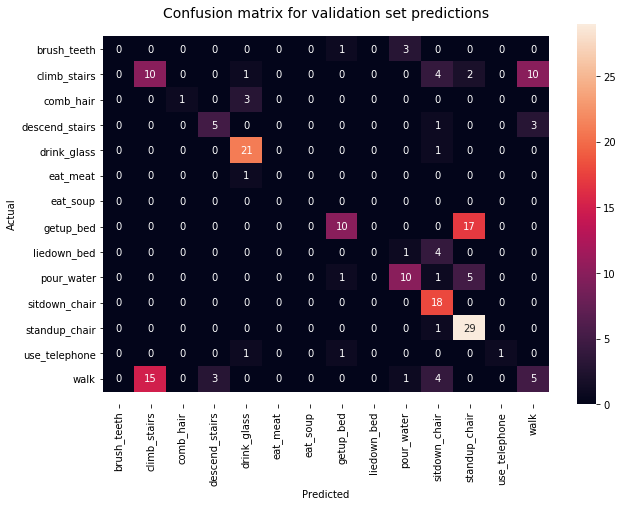

Accuracy: 56.41%
CPU times: user 3.67 s, sys: 2.74 s, total: 6.41 s
Wall time: 7min 53s


In [13]:
%%time
# Classify the validation examples and display accuracy and confusion matrix
acc, cm = clf.evaluate(X_val, y_val, labels=classes, n_jobs=-1)
show_results(acc, cm, dataset='validation', labels=classes)

In [14]:
from sequentia.classifiers import HMM, HMMClassifier

# Create HMMs to represent each class
hmms = []
for label in tqdm(classes, desc='Training HMMs'):
    hmm = HMM(label=label, n_states=10, random_state=rng)
    hmm.set_random_initial()
    hmm.set_random_transitions()
    hmm.fit([X_train[i] for i, y_i in enumerate(y_train) if y_i == label])
    hmms.append(hmm)
    
# Fit a HMM classifier with the HMMs
clf = HMMClassifier()
clf.fit(hmms)

UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


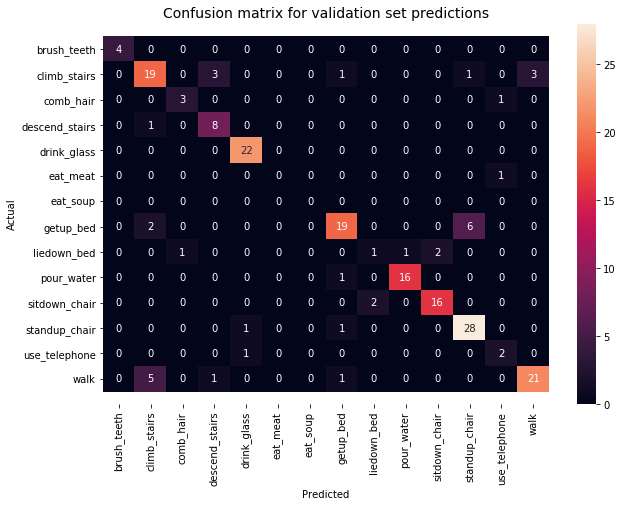

Accuracy: 81.54%
CPU times: user 2.92 s, sys: 229 ms, total: 3.15 s
Wall time: 2.97 s


In [15]:
%%time
# Classify the validation examples and display accuracy and confusion matrix
acc, cm = clf.evaluate(X_val, y_val, labels=classes)
show_results(acc, cm, dataset='validation', labels=classes)